In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import pathlib
from PIL import Image
import requests

In [2]:
# --- 1. Setup and Configuration ---

# Define key parameters for the project
IMAGE_SIZE = (224, 224) # The input size MobileNetV2 was trained on
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
SEED = 42

# Set seed for reproducibility
torch.manual_seed(SEED)

# Setup device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# --- 2. Download and Prepare the Dataset ---

# Download and extract the dataset if it's not already present
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = pathlib.Path(tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True))
data_dir = pathlib.Path('datasets/flower_photos')

# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Found {image_count} images in dataset.")

Found 453 images in dataset.


In [4]:
# --- 3. Data Augmentation and Preprocessing (PyTorch Transforms) ---

# Define transformations for the training and validation sets.
# Training transforms include data augmentation to make the model more robust.
# Validation transforms only include necessary resizing and normalization.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# --- 4. Create Datasets and DataLoaders ---

print("\nCreating PyTorch datasets and dataloaders...")

# Use ImageFolder to create a dataset from the directory structure
full_dataset = datasets.ImageFolder(data_dir)

# Split the full dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply the respective transformations to each dataset
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Get the class names
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Create DataLoaders to handle batching and shuffling
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


Creating PyTorch datasets and dataloaders...
Found 3 classes: ['roses', 'sunflowers', 'tulips']


In [6]:
# --- 5. Build the Model with Transfer Learning ---

print("\nBuilding the model with MobileNetV2 base...")

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')

# Freeze all the parameters in the feature extraction part of the model
for param in model.parameters():
    param.requires_grad = False

# Replace the final classifier layer (the "head") with a new one for our task.
# The new layers will have requires_grad=True by default, so they will be trained.
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, num_classes)
)

# Move the model to the configured device (GPU or CPU)
model = model.to(device)


Building the model with MobileNetV2 base...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\shahs_snohmej/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:06<00:00, 2.06MB/s]


In [7]:
# --- 6. Define Loss Function, Optimizer, and Scheduler ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE) # Only optimize the new classifier
# Learning rate scheduler to decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
# --- 7. Train the Model ---

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

print("\nStarting model training...")
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)
print("\nTraining finished.")


Starting model training...
Epoch 1/10
----------
Train Loss: 1.0703 Acc: 0.4227
Val Loss: 0.7665 Acc: 0.6154
Epoch 2/10
----------
Train Loss: 0.6424 Acc: 0.8066
Val Loss: 0.4911 Acc: 0.8132
Epoch 3/10
----------
Train Loss: 0.5120 Acc: 0.8177
Val Loss: 0.4002 Acc: 0.8901
Epoch 4/10
----------
Train Loss: 0.4417 Acc: 0.8370
Val Loss: 0.3644 Acc: 0.8901
Epoch 5/10
----------
Train Loss: 0.3784 Acc: 0.8729
Val Loss: 0.3411 Acc: 0.8791
Epoch 6/10
----------
Train Loss: 0.3295 Acc: 0.9061
Val Loss: 0.3240 Acc: 0.8681
Epoch 7/10
----------
Train Loss: 0.3669 Acc: 0.8674
Val Loss: 0.3371 Acc: 0.8901
Epoch 8/10
----------
Train Loss: 0.2992 Acc: 0.9116
Val Loss: 0.3212 Acc: 0.8791
Epoch 9/10
----------
Train Loss: 0.2812 Acc: 0.9171
Val Loss: 0.3153 Acc: 0.8571
Epoch 10/10
----------
Train Loss: 0.2837 Acc: 0.9171
Val Loss: 0.3179 Acc: 0.8681

Training complete in 6m 28s
Best val Acc: 0.890110

Training finished.



Plotting training history...


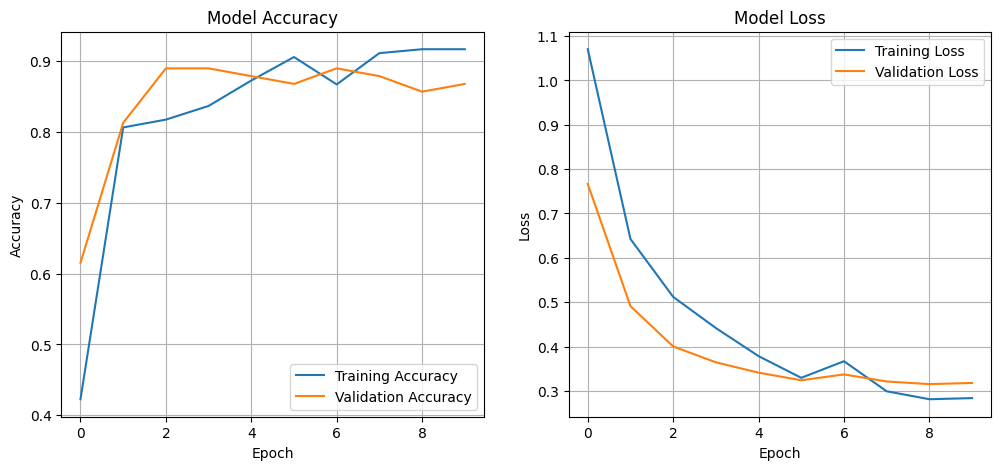

In [9]:
# --- 8. Evaluate and Plot Results ---

print("\nPlotting training history...")
acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


--- Making a prediction on a new image ---


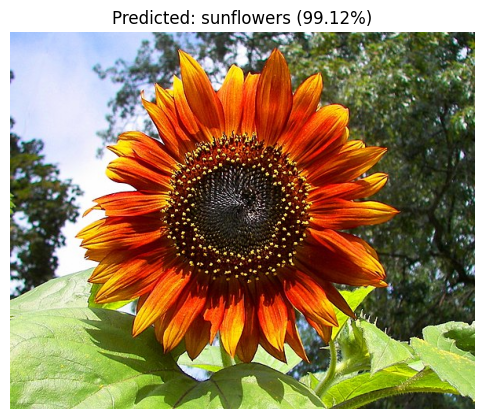

In [10]:
# --- 9. Make a Prediction on a New Image ---

def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(requests.get(image_path, stream=True).raw).convert('RGB')
    
    # Apply the same validation transforms
    transform = data_transforms['val']
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)
        predicted_class = class_names[predicted_idx.item()]

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} ({confidence.item():.2%})")
    plt.axis("off")
    plt.show()

print("\n--- Making a prediction on a new image ---")
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
predict_image(sunflower_url, model, class_names)